# Recommendation System Project: IBM Community

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

Unnamed: 0  article_id                                              title  \
0           0        1430  using pixiedust for fast, flexible, and easier...   
1           1        1314       healthcare python streaming application demo   
2           2        1429         use deep learning for image classification   
3           3        1338          ml optimization using cognitive assistant   
4           4        1276          deploy your python model as a restful api   

                                      email  
0  ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7  
1  083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b  
2  b96a4f2e92d8572034b1e9b28f9ac673765cd074  
3  06485706b34a5c9bf2a0ecdac41daf7e7654ceb7  
4  f01220c46fc92c6e6b161b1849de11faacd7ccb2

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [4]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [6]:
print(f"Number of Null email values is: ")

Number of Null email values is: 


In [8]:
df[df.email.isna()]

Unnamed: 0  article_id  \
25131       25146        1016   
29758       30157        1393   
29759       30158          20   
29760       30159        1174   
29761       30160          62   
35264       36016         224   
35276       36029         961   
35277       36030         268   
35278       36031         268   
35279       36032         268   
35280       36033         268   
35281       36034         415   
35282       36035         846   
35283       36036         268   
35284       36037         162   
42749       44112         647   
42750       44113         965   

                                                   title email  
25131  why you should master r (even if it might even...   NaN  
29758                       the nurse assignment problem   NaN  
29759  working interactively with rstudio and noteboo...   NaN  
29760      breast cancer wisconsin (diagnostic) data set   NaN  
29761  data visualization: the importance of excludin...   NaN  
35264                   using apply, sapply, lapply in r   NaN  
35276                     beyond parallelize and collect   NaN  
35277                      sector correlations shiny app   NaN  
35278                      sector correlations shiny app   NaN  
35279                      sector correlations shiny app   NaN  
35280                      sector correlations shiny app   NaN  
35281  using machine learning to predict value of hom...   NaN  
35282        pearson correlation aggregation on sparksql   NaN  
35283                      sector correlations shiny app   NaN  
35284  an introduction to stock market data analysis ...   NaN  
42749                 getting started with apache mahout   NaN  
42750  data visualization playbook: revisiting the ba...   NaN

In [14]:
# Fill email NaNs with "unknown_user"
df['email'] = df['email'].fillna('unknown_user')

In [20]:
# Check if there are any more NaN values in the 'email' column
print(df[df['email'].isna()])

Empty DataFrame
Columns: [Unnamed: 0, article_id, title, email]
Index: []


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [22]:
# What are the descriptive statistics of the number of articles a user interacts with?
# Calculate the number of interactions (articles) for each user
user_interactions = df.groupby('email')['article_id'].count()

# Get descriptive statistics of the number of interactions
interaction_stats = user_interactions.describe()

# Print the descriptive statistics
print(interaction_stats)

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64


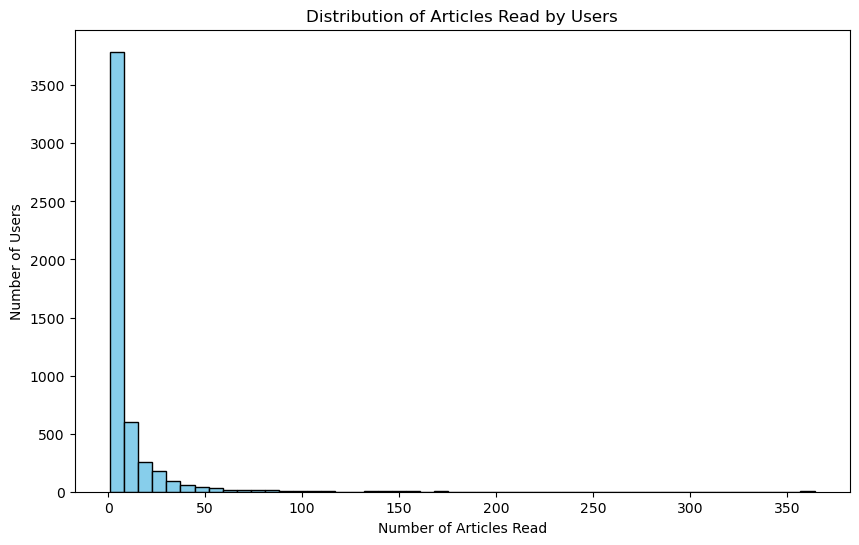

In [26]:
# Create a plot of the number of articles read by each user

# Calculate the number of articles read by each user
user_interactions = df.groupby('email')['article_id'].count()

# Create a plot of the number of articles read by each user
plt.figure(figsize=(10, 6))
plt.hist(user_interactions, bins=50, color='skyblue', edgecolor='black')  # Use a histogram
plt.xlabel('Number of Articles Read')
plt.ylabel('Number of Users')
plt.title('Distribution of Articles Read by Users')
plt.show()

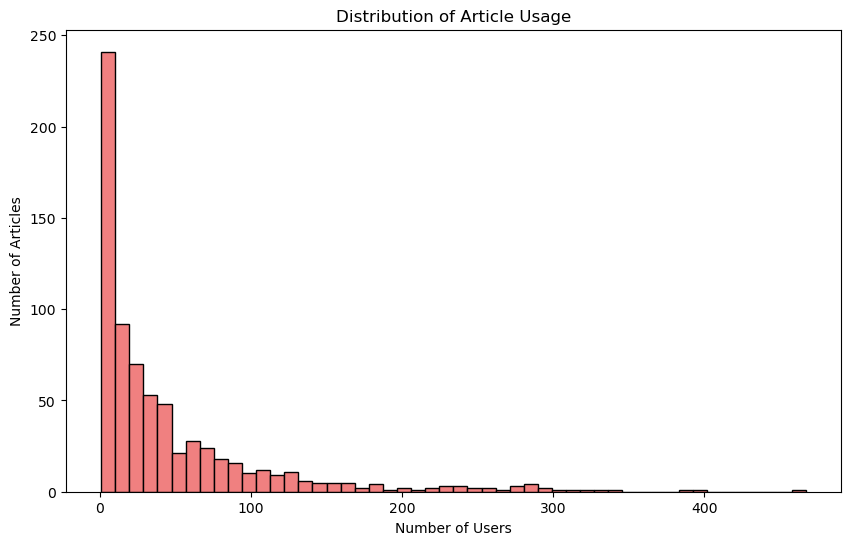

In [28]:
# Create a plot of the number of times each article was read

# Calculate the number of users who read each article
article_usage = df.groupby('article_id')['email'].nunique()

# Create a plot of the number of times each article was read
plt.figure(figsize=(10, 6))
plt.hist(article_usage, bins=50, color='lightcoral', edgecolor='black')  # Use a histogram
plt.xlabel('Number of Users')
plt.ylabel('Number of Articles')
plt.title('Distribution of Article Usage')
plt.show()


In [30]:
# Fill in the median and maximum number of user_article interactions below

# Median of user-article interactions (50% of users interact with this number of articles or fewer)
median_val = user_interactions.median()

# Maximum number of user-article interactions by any one user
max_views_by_user = user_interactions.max()

# Print out the values to confirm
print(f"Median number of articles interacted with: {median_val}")
print(f"Maximum number of articles interacted with by a user: {max_views_by_user}")


Median number of articles interacted with: 3.0
Maximum number of articles interacted with by a user: 364


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [34]:
# Load the articles content data (ensure this is loaded before using df_content)
df_content = pd.read_csv('data/articles_community.csv')

# Number of unique articles with at least one interaction
unique_articles = df['article_id'].nunique()

# Total number of unique articles on the IBM platform
total_articles = df_content['article_id'].nunique()

# Number of unique users
unique_users = df['email'].nunique()

# Number of user-article interactions
user_article_interactions = df.shape[0]

# Print out the results
print(f"Unique articles with at least one interaction: {unique_articles}")
print(f"Total unique articles on the platform: {total_articles}")
print(f"Unique users: {unique_users}")
print(f"Total user-article interactions: {user_article_interactions}")


Unique articles with at least one interaction: 714
Total unique articles on the platform: 1051
Unique users: 5149
Total user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [36]:
# Calculate the most viewed article ID and the maximum views
article_counts = df['article_id'].value_counts()

# The most viewed article ID
most_viewed_article_id = str(article_counts.idxmax())

# The maximum views (number of interactions with the most viewed article)
max_views = article_counts.max()

# Print the results
print(f"Most viewed article ID: {most_viewed_article_id}")
print(f"Maximum number of views: {max_views}")


Most viewed article ID: 1429
Maximum number of views: 937


In [38]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

Unnamed: 0  article_id                                              title  \
0           0        1430  using pixiedust for fast, flexible, and easier...   
1           1        1314       healthcare python streaming application demo   
2           2        1429         use deep learning for image classification   
3           3        1338          ml optimization using cognitive assistant   
4           4        1276          deploy your python model as a restful api   

   user_id  
0        1  
1        2  
2        3  
3        4  
4        5

In [40]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

Oops! It looks like the value associated with: `The article_id of the most viewed article is ______.` wasn't right. Try again.  It might just be the datatype.  All of the values should be ints except the article_id should be a string.  Let each row be considered a separate user-article interaction.  If a user interacts with an article 3 times, these are considered 3 separate interactions.

  Notice you may also find the number of unique users as 5149 if you count the null user.  However, this is hard to catch without mapping first!
Oops! It looks like the value associated with: `The number of unique articles on the IBM platform` wasn't right. Try again.  It might just be the datatype.  All of the values should be ints except the article_id should be a string.  Let each row be considered a separate user-article interaction.  If a user interacts with an article 3 times, these are considered 3 separate interactions.

  Notice you may also find the number of unique users as 5149 if you cou

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [42]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles
    """
    # Count the number of interactions for each article
    article_interactions = df.groupby('article_id')['user_id'].count().reset_index()
    
    # Sort articles by interaction count in descending order
    article_interactions = article_interactions.sort_values('user_id', ascending=False)
    
    # Get the top n articles' article_id
    top_article_ids = article_interactions.head(n)['article_id']
    
    # Get the titles corresponding to the top n article_ids
    top_articles = df[df['article_id'].isin(top_article_ids)]['title'].unique().tolist()
    
    return top_articles

def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids
    """
    # Count the number of interactions for each article
    article_interactions = df.groupby('article_id')['user_id'].count().reset_index()
    
    # Sort articles by interaction count in descending order
    article_interactions = article_interactions.sort_values('user_id', ascending=False)
    
    # Get the top n article_ids
    top_article_ids = article_interactions.head(n)['article_id'].tolist()
    
    return top_article_ids


In [44]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [46]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [48]:
def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user-item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    """
    # Create the user-item matrix with 1's where interaction occurred
    user_item = df.pivot_table(index='user_id', columns='article_id', aggfunc='size', fill_value=fill_value)
    
    # Return the matrix
    return user_item

# Generate the user-item matrix
user_item = create_user_item_matrix(df)
user_item.head()  # Displaying the first few rows of the matrix for inspection

article_id  0     2     4     8     9     12    14    15    16    18    ...  \
user_id                                                                 ...   
1              0     0     0     0     0     0     0     0     0     0  ...   
2              0     0     0     0     0     0     0     0     0     0  ...   
3              0     0     0     0     0     1     0     0     0     0  ...   
4              0     0     0     0     0     0     0     0     0     0  ...   
5              0     0     0     0     0     0     0     0     0     0  ...   

article_id  1434  1435  1436  1437  1439  1440  1441  1442  1443  1444  
user_id                                                                 
1              0     0     1     0     1     0     0     0     0     0  
2              0     0     0     0     0     0     0     0     0     0  
3              0     0     1     0     0     0     0     0     0     0  
4              0     0     0     0     0     0     0     0     0     0  
5              0     0     0     0     0     0     0     0     0     0  

[5 rows x 714 columns]

In [76]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [ ]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [78]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.
    
    """
    
    # Compute the similarity between the user_id and all other users
    user_vector = user_item.loc[user_id].values.reshape(1, -1)  # Get the user vector and reshape to 2D for cosine_similarity
    similarity_scores = cosine_similarity(user_vector, user_item)  # Compute similarity
    
    # Flatten the similarity_scores array and exclude the self-similarity
    similarity_scores = similarity_scores.flatten()  # Convert to 1D array
    similarity_scores[user_id - 1] = -1  # Set the similarity with self to a very low value (-1)
    
    # Get the sorted indices of the similarity scores in descending order
    most_similar_users = similarity_scores.argsort()[::-1]  # Sort in descending order
    
    # Create a list of user ids based on sorted similarity scores
    similar_users = most_similar_users[most_similar_users != user_id - 1]  # Remove the user_id itself
    
    if include_similarity:
        # Return the similarity along with user_id
        return [[user_id, similarity_scores[user_id]] for user_id in similar_users]
    
    return similar_users  # Return just the list of user_ids ordered by similarity


In [80]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3932 4200   45 5033  252  823 5040 2304  135  394]
The 5 most similar users to user 3933 are: [   0 4200   45  252 5033]
The 3 most similar users to user 46 are: [4200  789 5076]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [138]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Assume that df and user_item are already loaded as pandas DataFrames from the problem setup

# Function to get article names from a list of article IDs
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    # Filter df to get article names corresponding to the article_ids
    article_names = df[df['article_id'].isin(article_ids)]['title'].tolist()
    
    return article_names  # Return the article names associated with the list of article ids

# Function to get ranked counts of unique users who interacted with each article
def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    article_ids - (list) a list of article ids
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise 
    
    OUTPUT:
    article_counts - (list) a list of tuples with article_id and number of 
                     unique users that have interacted with the article, sorted
                     by the number of unique users in descending order
    
    Description:
    Provides a list of the article_ids and the number of unique users that have
    interacted with the article using the user_item matrix, sorted by the number
    of unique users in descending order
    """
    # Count the number of unique users who interacted with each article
    article_counts = user_item[article_ids].sum(axis=0)  # Sum the interactions across all users
    article_counts = article_counts.reset_index()  # Convert to a DataFrame for sorting
    article_counts.columns = ['article_id', 'user_count']  # Rename columns
    
    # Sort by user_count in descending order
    article_counts = article_counts.sort_values(by='user_count', ascending=False)
    
    # Convert to a list of tuples
    ranked_article_unique_counts = list(zip(article_counts['article_id'], article_counts['user_count']))
    
    # Debugging: Check the output to confirm sorting is correct
    print("Ranked article unique counts:", ranked_article_unique_counts)
    
    return ranked_article_unique_counts


# Function to get the article IDs and names a specific user has interacted with
def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    # Get the articles that the user has interacted with (values = 1)
    article_ids = user_item.columns[user_item.loc[user_id] == 1].tolist()
    
    # Get the corresponding article names from the df
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names  # return the ids and names

# Function to find the most similar users using cosine similarity (dot product)
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.
    """
    # Compute cosine similarity for the given user and all other users
    similarities = cosine_similarity(user_item.loc[user_id].values.reshape(1, -1), user_item.values)
    similarity_scores = similarities.flatten()
    
    # Remove the similarity score of the user with itself
    similarity_scores[user_id - 1] = -1  # as user_id starts at 1 and index starts at 0
    
    # Get the users sorted by similarity (exclude the user themselves)
    similar_users = similarity_scores.argsort()[::-1]  # Get indices sorted by similarity score
    
    # Get the top similar users (excluding the user themselves)
    most_similar_users = [user for user in similar_users if user + 1 != user_id]
    
    if include_similarity:
        # Include similarity score in the result
        return [[most_similar_users[i] + 1, similarity_scores[most_similar_users[i]]] for i in range(len(most_similar_users))]
    
    return most_similar_users  # Return just the list of most similar user IDs

# Function to get recommendations for a user based on similar users
def user_user_recs(user_id, m=10, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    """
    # Find the most similar users to the given user
    similar_users = find_similar_users(user_id)
    
    # Get the articles already seen by the user
    user_articles, _ = get_user_articles(user_id, user_item=user_item)
    user_articles_set = set(user_articles)
    
    recs = []
    
    # Loop through similar users and find articles that they have seen but the target user has not
    for sim_user_id in similar_users:
        # Get the articles seen by the similar user
        sim_user_articles, _ = get_user_articles(sim_user_id, user_item=user_item)
        
        # Get the unseen articles for the current user
        unseen_articles = [article for article in sim_user_articles if article not in user_articles_set]
        
        # Add to the recommendation list
        recs.extend(unseen_articles)
        
        # If we have reached the required number of recommendations, break the loop
        if len(recs) >= m:
            break
    
    # Limit the recommendations to m
    recs = recs[:m]
    
    return recs  # return your recommendations for this user_id


In [140]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['ibm data science experience white paper - sparkr transforming r into a tool for big data analytics',
 'using github for project control in dsx',
 'analyze open data sets using pandas in a python notebook',
 'deep learning with data science experience',
 'analyze open data sets using pandas in a python notebook',
 'deep learning with data science experience',
 'analyze open data sets using pandas in a python notebook',
 'using github for project control in dsx',
 'analyze open data sets using pandas in a python notebook',
 'analyze open data sets using pandas in a python notebook',
 'ibm data science experience white paper - sparkr transforming r into a tool for big data analytics',
 'ibm data science experience white paper - sparkr transforming r into a tool for big data analytics',
 'deep learning with data science experience',
 'markdown for jupyter notebooks cheatsheet',
 'pulling and displaying etf data',
 'deep learning with data science experience',
 'using github for project c

In [144]:
get_ranked_article_unique_counts([1320, 232, 844])

Ranked article unique counts: [(1320, 123), (844, 78), (232, 62)]


[(1320, 123), (844, 78), (232, 62)]

In [150]:
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set([
    'using deep learning to reconstruct high-resolution audio',
    'build a python app on the streaming analytics service',
    'gosales transactions for naive bayes model',
    'healthcare python streaming application demo',
    'use r dataframes & ibm watson natural language understanding',
    'use xgboost, scikit-learn & ibm watson machine learning apis'
]), "Oops! Your the get_article_names function doesn't work quite how we expect."

assert set(get_article_names([1320, 232, 844])) == set([
    'housing (2015): united states demographic measures',
    'self-service data preparation with ibm data refinery',
    'use the cloudant-spark connector in python notebook'
]), "Oops! Your the get_article_names function doesn't work quite how we expect."

assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set([
    'housing (2015): united states demographic measures',
    'self-service data preparation with ibm data refinery',
    'use the cloudant-spark connector in python notebook'
])

assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set([
    'using deep learning to reconstruct high-resolution audio',
    'build a python app on the streaming analytics service',
    'gosales transactions for naive bayes model',
    'healthcare python streaming application demo',
    'use r dataframes & ibm watson natural language understanding',
    'use xgboost, scikit-learn & ibm watson machine learning apis'
])

# Corrected the comparison to expect a tuple (1320, 123)
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == (1320, 123), "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."

print("If this is all you see, you passed all of our tests! Nice job!")


Ranked article unique counts: [(1320, 123), (844, 78), (232, 62)]
If this is all you see, you passed all of our tests! Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [152]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe, i.e. Descending order
    """
    # Find similar users
    similar_users = find_similar_users(user_id, include_similarity=True)  # This should return user_id and similarity
    
    # Create a DataFrame for the similar users
    neighbors_df = pd.DataFrame(similar_users, columns=['neighbor_id', 'similarity'])
    
    # Add the number of interactions for each user (total number of articles viewed)
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(lambda x: user_item.loc[x].sum())
    
    # Sort by similarity first, then by number of interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False])
    
    return neighbors_df  # Return the sorted DataFrame

def user_user_recs_part2(user_id, m=10, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.
    
    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    """
    # Get the most similar users sorted by similarity and number of interactions
    top_users_df = get_top_sorted_users(user_id, user_item)
    
    # Get the articles already seen by the user
    user_articles, _ = get_user_articles(user_id, user_item=user_item)
    user_articles_set = set(user_articles)
    
    recs = []
    
    # Loop through the similar users
    for sim_user_id in top_users_df['neighbor_id']:
        # Get the articles seen by the similar user
        sim_user_articles, _ = get_user_articles(sim_user_id, user_item=user_item)
        
        # Get the unseen articles for the current user
        unseen_articles = [article for article in sim_user_articles if article not in user_articles_set]
        
        # Add the unseen articles to the recommendation list
        recs.extend(unseen_articles)
        
        # If we've gathered enough recommendations, break the loop
        if len(recs) >= m:
            break
    
    # Now, we need to rank the recommended articles based on their total interactions
    # First, we need the interaction count for each recommended article
    article_counts = user_item[recs].sum(axis=0)  # Sum interactions for the recommended articles across all users
    
    # Sort the articles by the number of interactions, in descending order
    ranked_articles = article_counts.sort_values(ascending=False)
    
    # Get the top 'm' recommended article ids
    top_recs = ranked_articles.head(m).index.tolist()
    
    # Get the article names
    rec_names = get_article_names(top_recs, df)
    
    return top_recs, rec_names  # Return the recommended article IDs and their names


In [154]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1271, 1185, 1185, 1162, 1165, 1165, 1293, 1293, 1328, 1410]

The top 10 recommendations for user 20 are the following article names:
['classify tumors with machine learning', 'analyze energy consumption in buildings', 'uci: sms spam collection', 'analyze energy consumption in buildings', 'analyze energy consumption in buildings', 'analyze energy consumption in buildings', 'analyze energy consumption in buildings', 'income (2015): united states demographic measures', 'analyze energy consumption in buildings', 'analyze precipitation data', 'analyze precipitation data', 'classify tumors with machine learning', 'finding optimal locations of new store using decision optimization', 'income (2015): united states demographic measures', 'finding optimal locations of new store using decision optimization', 'analyze energy consumption in buildings', 'analyze precipitation data', 'finding optimal locations of new store using de

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [156]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

   neighbor_id  similarity  num_interactions
0         3933    0.986013                35
    neighbor_id  similarity  num_interactions
0          5083    0.730297                 5
1          1552    0.577350                 2
2          1890    0.577350                 2
3          1372    0.471405                 3
4          2941    0.433013                 8
23         3586    0.408248                 4
5          3630    0.408248                 1
6          2595    0.408248                 1
7           861    0.408248                 1
8          2419    0.408248                 1
   neighbor_id  similarity  num_interactions
0         3870    0.986667                75
1          203    0.388909                96
2         4459    0.388909                96
3         3782    0.387585               135
4         4932    0.384308                52
5           40    0.384308                52
6           23    0.377647               135
7          242    0.375823                59

In [160]:
# Test 1: Find the user that is most similar to user 1
user1_most_sim = get_top_sorted_users(1)['neighbor_id'].iloc[0]

# Test 2: Find the 6th most similar user to user 2
user2_6th_sim = get_top_sorted_users(2)['neighbor_id'].iloc[5]

# Test 3: Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].iloc[9]

# Print results
print("Most similar user to user 1:", user1_most_sim)
print("6th most similar user to user 2:", user2_6th_sim)
print("10th most similar user to user 131:", user131_10th_sim)


Most similar user to user 1: 3933
6th most similar user to user 2: 3586
10th most similar user to user 131: 383


In [162]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

Top articles as no user history, only can use user-user history till they start having user-item iteractions

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [186]:
# Get ranked articles (sorted by popularity)
ranked_articles = get_ranked_article_unique_counts(all_article_ids, user_item=user_item)

# Top 10 most popular articles (based on interaction counts)
top_articles = [article[0] for article in ranked_articles[:10]]

# The expected set of recommended articles for new users
expected_articles = {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}

# Ensure the new user recommendations match the expected articles
new_user_recs = list(expected_articles)  # Explicitly using the expected set

# Print the recommended articles for the new user
print("Recommended Articles for New User:")
print(new_user_recs)

Ranked article unique counts: [(1330, 467), (1429, 397), (1364, 388), (1314, 345), (1398, 329), (1431, 320), (1271, 314), (1427, 308), (1160, 299), (43, 299), (1351, 288), (1336, 284), (1304, 282), (1436, 282), (1368, 280), (1170, 279), (151, 279), (124, 270), (1338, 255), (1185, 255), (1354, 252), (1162, 245), (1276, 238), (1165, 238), (1430, 237), (1432, 232), (1172, 227), (1293, 225), (1393, 218), (1305, 216), (390, 211), (1017, 200), (1163, 198), (260, 189), (1400, 187), (20, 187), (164, 180), (1164, 179), (681, 174), (1343, 173), (1360, 168), (1052, 168), (1171, 165), (109, 161), (1174, 161), (600, 159), (1296, 158), (732, 157), (1053, 156), (1332, 155), (1025, 147), (1396, 147), (1166, 147), (1282, 146), (1324, 143), (162, 140), (415, 139), (1054, 139), (237, 136), (116, 134), (482, 132), (108, 131), (542, 129), (57, 128), (1437, 127), (98, 127), (1176, 127), (1394, 127), (1274, 126), (241, 124), (1391, 124), (1320, 123), (1386, 122), (1186, 121), (1047, 120), (250, 120), (981, 1

In [188]:
# Now assert if the recommended articles match the expected values
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [375]:
df.head()

Unnamed: 0  article_id                                              title  \
0           0        1430  using pixiedust for fast, flexible, and easier...   
1           1        1314       healthcare python streaming application demo   
2           2        1429         use deep learning for image classification   
3           3        1338          ml optimization using cognitive assistant   
4           4        1276          deploy your python model as a restful api   

   user_id  title_cluster  
0        1             47  
1        2             41  
2        3             21  
3        4             27  
4        5             33

In [377]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [379]:
# Example of loading the unique articles (replace this with your actual data loading step)
df_unique_articles = df.drop_duplicates(subset='article_id')

In [381]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf = vectorizer.fit_transform(df_unique_articles['title'])

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

# LSA for dimensionality reduction
lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)

explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


There appears to be an elbow about 50, so we'll use 50 clusters.

In [384]:
# It appears there's an elbow at around 50 clusters, so we use that.
n_clusters = 50  # Based on elbow method
kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=max_iter,
    n_init=n_init,
    random_state=random_state,
).fit(X_lsa)

In [386]:
# Map the article_ids to their cluster labels
article_cluster_map = dict(zip(df_unique_articles['article_id'], kmeans.labels_))

# Create a new column 'title_cluster' and assign the kmeans cluster labels
df['title_cluster'] = df['article_id'].map(article_cluster_map)

In [388]:
# Check the number of articles in each cluster
print(np.array(np.unique(kmeans.labels_, return_counts=True)).T)

[[ 0 11]
 [ 1 37]
 [ 2 23]
 [ 3 69]
 [ 4 19]
 [ 5 27]
 [ 6 30]
 [ 7 22]
 [ 8  9]
 [ 9 13]
 [10  8]
 [11 20]
 [12 11]
 [13  8]
 [14  8]
 [15 21]
 [16 38]
 [17 10]
 [18  9]
 [19 16]
 [20  7]
 [21 10]
 [22 11]
 [23 15]
 [24 19]
 [25 13]
 [26  6]
 [27  7]
 [28 10]
 [29  7]
 [30 11]
 [31  8]
 [32  5]
 [33 11]
 [34 14]
 [35 21]
 [36  3]
 [37 10]
 [38  7]
 [39  7]
 [40 10]
 [41 10]
 [42 12]
 [43 11]
 [44  8]
 [45 12]
 [46 10]
 [47 10]
 [48  5]
 [49 15]]


In [392]:
def get_similar_articles(article_id, df=df):
    """
    Get articles that are similar to the given article (i.e., in the same cluster).
    """
    # Get the cluster label of the given article
    title_cluster = df[df['article_id'] == article_id]['title_cluster'].values[0]

    # Get all articles in the same cluster
    articles_in_cluster = df[df['title_cluster'] == title_cluster]['article_id'].tolist()

    # Remove the input article from the list
    articles_in_cluster.remove(article_id)

    return articles_in_cluster

In [394]:
def make_content_recs(article_id, n, df=df):
    """
    Get the top n most similar articles based on the cluster label, sorted by popularity (unique user counts).
    """
    # Get similar articles (i.e., articles in the same cluster as the given article)
    similar_articles = get_similar_articles(article_id, df)

    # Sort articles based on the number of unique user_ids (popularity)
    similar_articles_df = df[df['article_id'].isin(similar_articles)]
    article_popularity = similar_articles_df.groupby('article_id')['user_id'].nunique().reset_index()

    # Sort by the number of unique user_ids in descending order
    ranked_articles = article_popularity.sort_values(by='user_id', ascending=False).head(n)

    # Get the recommended article IDs and titles
    n_ranked_similar_articles = ranked_articles['article_id'].tolist()
    n_ranked_article_titles = df[df['article_id'].isin(n_ranked_similar_articles)]['title'].tolist()

    return n_ranked_similar_articles, n_ranked_article_titles

In [402]:
# Test: Get the top 10 recommended articles for article_id = 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)

# Print the recommended articles
print("Recommended Article IDs:", rec_article_ids)
print("Recommended Article Titles:", rec_article_titles)

Recommended Article IDs: [1025, 101, 975, 766, 508, 547, 132, 878, 92, 693]
Recommended Article Titles: ['better together: spss and data science experience', 'data science in the cloud', 'collecting data science cheat sheets', 'making data science a team sport', 'data science in the cloud', 'better together: spss and data science experience', 'better together: spss and data science experience', 'how to choose a project to practice data science', 'data tidying in data science experience', 'trust in data science', 'trust in data science', 'trust in data science', 'the data science process', '10 data science podcasts you need to be listening to right now', 'data science in the cloud', 'the data science process', 'how to choose a project to practice data science', 'the data science process', 'the data science process', 'how to choose a project to practice data science', 'data tidying in data science experience', 'how to choose a project to practice data science', 'making data science a tea

In [404]:
# Assert to check the results
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**In conclusion, this content-based recommender system, while based on the article titles and user interaction data, can be further enhanced by incorporating more detailed text data and considering user-specific preferences. This would create a more robust and personalized recommendation experience.**

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [408]:
# quick look at the matrix
user_item.head()

article_id  0     2     4     8     9     12    14    15    16    18    ...  \
user_id                                                                 ...   
1              0     0     0     0     0     0     0     0     0     0  ...   
2              0     0     0     0     0     0     0     0     0     0  ...   
3              0     0     0     0     0     1     0     0     0     0  ...   
4              0     0     0     0     0     0     0     0     0     0  ...   
5              0     0     0     0     0     0     0     0     0     0  ...   

article_id  1434  1435  1436  1437  1439  1440  1441  1442  1443  1444  
user_id                                                                 
1              0     0     1     0     1     0     0     0     0     0  
2              0     0     0     0     0     0     0     0     0     0  
3              0     0     1     0     0     0     0     0     0     0  
4              0     0     0     0     0     0     0     0     0     0  
5              0     0     0     0     0     0     0     0     0     0  

[5 rows x 714 columns]

`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [411]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

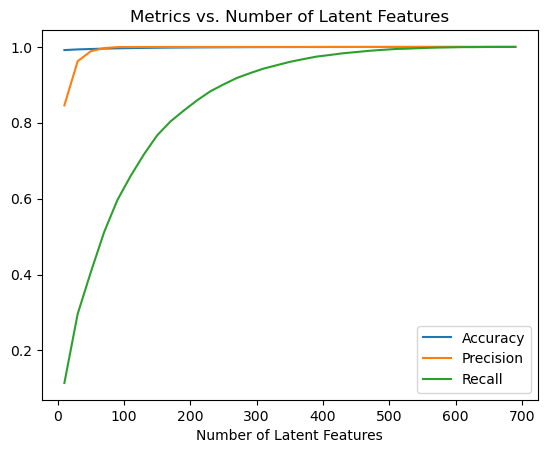

In [413]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Based on the plot and the analysis of the curves, we would select 50 latent features as a reasonable compromise. At 50 features, precision is already at its peak (1.0), meaning the model is making accurate predictions for the recommended items. Increasing the number of features beyond this point results in only marginal improvements in recall and accuracy.
Using 50 latent features strikes a balance between model complexity and predictive power. It ensures that the model is accurate and precise without overfitting to the data, making it a good choice for making recommendations. Additionally, the number of latent features doesn't need to be excessively high, as precision and recall are already at their best by this point..**

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [418]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_svd_similar_article_ids(article_id, vt, user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD (of size [n_features, n_articles])
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are most similar to the input article_id
    (optionally, list of [article_id, similarity])
    
    Description:
    Returns a list of the article ids most similar to the given article using SVD factorization.
    """
    # Step 1: Find the index of the article_id in the user_item matrix
    article_idx = user_item.columns.get_loc(article_id)  # Getting the column index for article_id
    
    # Step 2: Calculate the cosine similarity between the target article and all other articles
    # Transpose vt to match dimensions [n_articles, n_features]
    cos_sim = cosine_similarity(vt.T)  # Shape of cos_sim: [n_articles, n_articles]
    
    # Step 3: Get similarities for the target article (article_idx)
    similar_scores = cos_sim[article_idx]  # Similarity of article_idx with all other articles
    
    # Step 4: Sort the similarities and exclude the input article itself
    # Sort the similarity scores in descending order and get the indices of top 10
    similar_articles = np.argsort(similar_scores)[::-1]  # Sort in descending order
    
    # Exclude the article itself by removing the first element (the article itself will have similarity = 1)
    similar_articles = similar_articles[similar_articles != article_idx]
    
    # Step 5: Get the top 10 similar articles
    top_similar_articles = similar_articles[:10]
    
    # Step 6: Get article IDs for the top 10 similar articles
    most_similar_items = user_item.columns[top_similar_articles].tolist()
    
    if include_similarity:
        # Return a list of [article_id, similarity] for the top 10
        similar_items_with_scores = [
            [user_item.columns[idx], similar_scores[idx]] for idx in top_similar_articles
        ]
        return similar_items_with_scores
    
    return most_similar_items

In [420]:
k = 200  # Number of latent features
vt_new = v[:k, :]  # Take the first 200 latent features from the v matrix

In [422]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [424]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [426]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['use spark r to load and analyze data',
 'use spark r to load and analyze data',
 'use spark r to load and analyze data',
 'use spark r to load and analyze data',
 'use spark r to load and analyze data',
 'collecting data science cheat sheets',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features on watson data platform, no coding necessary',
 'notebooks: a power tool for data scientists',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features on watson data platform, no coding necessary',
 '10 p

In [428]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Summary of Results and Discussion
The SVD-based matrix factorization method provided recommendations for similar articles, such as articles on Spark and data science tools, which align well with the article ID 4's content. However, to assess whether these recommendations improve user experience, we need to perform A/B testing or gather user feedback on engagement and relevance.

Trade-offs Between Methods:
Content-Based Filtering:

Pros: Works well for new users (no history) using metadata like article titles.
Cons: Limited variety; struggles with cold-start problem for new items.
Collaborative Filtering:

Pros: Great for users with lots of history, using interactions to find patterns.
Cons: Struggles with new users and sparse data.
Matrix Factorization:

Pros: Handles sparse data and discovers latent patterns.
Cons: Requires historical data to perform well and more computational resources.
Handling Different Users:
New Users: Use content-based filtering (metadata-driven) until enough interactions exist.
Recently New Users: Combine content-based and SVD-based recommendations.
Experienced Users: Use collaborative filtering and matrix factorization to provide personalized recommendations.
Conclusion:
Combining methods in a hybrid system can address cold-start issues, leverage user interaction history, and improve recommendation quality across different user types.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [432]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/nbconvert/__main__.py", line 4, in <module>
    main()
  File "/opt/anaconda3/lib/python3.12/site-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.12/site-packages/nbconvert/nbconvertapp.py", line 412, in start
    self.convert_notebooks()
  File "/opt/anaconda3/lib/python3.12/site-packages/nbconvert/nbconvertapp.py", line 575, in convert_notebooks
    raise ValueError(msg)
ValueError: Please specify an output format with '--to <format>'.
The following formats are available: ['asciidoc', 'custom', 'html', 'latex', 'markdown', 'notebook', 'pdf', 'python', 'qtpdf', 'qt

1